# A-weighting filter implementation

The A-weighting transfer function is defined in the ANSI Standards S1.4-1983 and S1.42-2001:

$$
H(s) = \frac{\omega_4^2 s^4}{(s-\omega_1)^2(s-\omega_2)(s-\omega_3)(s-\omega_4)^2}
$$

Where $\omega_i = 2\pi f_i$ are the angular frequencies defined by:

In [1]:
import numpy as np

f1 = 20.598997 # Hz
f4 = 12194.217 # Hz
f2 = 107.65265 # Hz
f3 = 737.86223 # Hz

w1 = 2*np.pi*f1 # rad/s
w2 = 2*np.pi*f2 # rad/s
w3 = 2*np.pi*f3 # rad/s
w4 = 2*np.pi*f4 # rad/s

In [1] ther is a method to convert this function transform to a discrete time-domain using the bilinear transform. We use a similar method, but we separate it into four filters of order one or two, in order to keep the filter stable:

$$
H(s) = \omega_4^2 H_1(s) H_2(s) H_3(s) H_4(s),
$$
where:

$$
H_i(s) = \left\{ \begin{array}{lcc}
             \frac{s}{(s-\omega_i)^2} &   \text{for}  & i=1,4 \\
             \\ \frac{s}{(s-\omega_i)} &  \text{for} & i = 2,3. \\
             \end{array}
   \right.
$$

Now, we conver the $H_i(s)$ filters to their discrete-time implementation by using the bilinear transform:

$$
s \rightarrow 2f_s\frac{1+z^{-1}}{1-z^{-1}}.
$$

Therefore:

$$
H_i(z) = \frac{2f_s(1-z^{-2})}{(\omega_i-2f_s)^2z^{-2}+2(\omega_i^2-4f_s^2)z^{-1}+(\omega_i+2f_s)^2} \text{ for } i = 1,4
$$

$$
H_i(z) = \frac{2f_s(1-z^{-1})}{(\omega_i-2f_s)z^{-1}+(\omega_i+2f_s)} \text{ for } i = 2,3
$$

We define two python functions to calculates coefficients of both types of function transforms:

In [2]:
def filter_first_order(w,fs): #s/(s+w)
    a0 = w + 2.0*fs    
    b = 2*fs*np.array([1, -1])/a0
    a = np.array([a0, w - 2*fs])/a0
    return b,a

def filter_second_order(w,fs): #s/(s+w)^2
    a0 = (w + 2.0*fs)**2    
    b = 2*fs*np.array([1,0,-1])/a0
    a = np.array([a0,2*(w**2-4*fs**2),(w-2*fs)**2])/a0
    return b,a

Now, we calculate b and a coefficients of the four filters for some sampling rate:

In [3]:
fs = 48000 #Hz

b1,a1 = filter_second_order(w1,fs)
b2,a2 = filter_first_order(w2,fs)
b3,a3 = filter_first_order(w3,fs)
b4,a4 = filter_second_order(w4,fs)

Then, we calculate the impulse response of the overall filter, $h[n]$, by concatenating the four filters and using the impulse signal, $\delta[n]$, as input. 

In [4]:
from scipy import signal

# generate delta[n]
N = 8192*2 #number of points
delta = np.zeros(N)
delta[0] = 1

# apply filters
x1 = signal.lfilter(b1,a1,delta)
x2 = signal.lfilter(b2,a2,x1)
x3 = signal.lfilter(b3,a3,x2)
h = signal.lfilter(b4,a4,x3)

GA = 10**(2/20.) # 0dB at 1Khz
h = h*GA*w4**2 

Lets find the filter's frequency response, $H(e^{j\omega})$, by calcuating the FFT of $h[n]$.

In [5]:
H = np.abs(np.fft.fft(h))[:N/2]
H = 20*np.log10(H)

Compare the frequency response to the expresion defined in the norms:

In [6]:
eps = 10**-6
f = np.linspace(0,fs/2-fs/float(N),N/2)
curveA = f4**2*f**4/((f**2+f1**2)*np.sqrt((f**2+f2**2)*(f**2+f3**2))*(f**2+f4**2))
HA = 20*np.log10(curveA+eps)+2.0

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.title('Digital filter frequency response')
plt.plot(f,H, 'b',label= 'Devised filter')
plt.plot(f,HA, 'r',label= 'Norm filter')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.xscale('log')
plt.xlim([10,fs/2.0])
plt.ylim([-80,3])
plt.grid()
plt.show()

<Figure size 1000x1000 with 1 Axes>

Now we also can check if the filter designed fullfill the tolerances given in the ANSI norm [2].

In [8]:
import csv

freqs = []
tol_type0_low = []
tol_type0_high = []
tol_type1_low = []
tol_type1_high = []

with open('ANSI_tolerances.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            #print('Column names are {", ".join(row)}')
            line_count += 1
        else:
            freqs.append(float(row[0]))
            Aw = float(row[1])
            tol_type0_low.append(Aw + float(row[2]))
            tol_type0_high.append(Aw + float(row[3]))
            tol_type1_low.append(Aw + float(row[4]))
            
            if row[5] != '':
                tol_type1_high.append(Aw + float(row[5]))  
            else:
                tol_type1_high.append(np.Inf) 
            line_count += 1
    print('Processed %d lines.'%line_count)

Processed 35 lines.


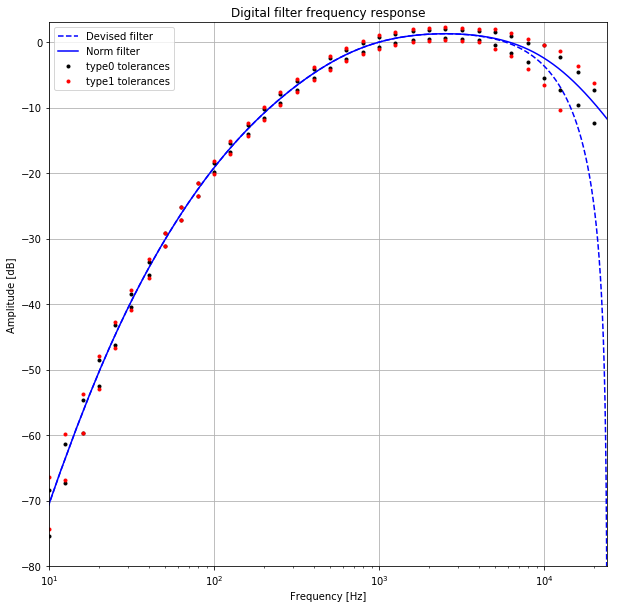

In [9]:
fig = plt.figure(figsize=(10,10))
plt.title('Digital filter frequency response')
plt.plot(f,H, 'b--',label= 'Devised filter')
plt.plot(f,HA, 'b-',label= 'Norm filter')
#plt.errorbar(freqs, curveA, yerr=tol_type0.T)
#plt.errorbar(freqs, curveA, yerr=tol_type1.T)
plt.plot(freqs,tol_type0_low,'k.',label='type0 tolerances')
plt.plot(freqs,tol_type0_high,'k.')
plt.plot(freqs,tol_type1_low,'r.',label='type1 tolerances')
plt.plot(freqs,tol_type1_high,'r.')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.xscale('log')
plt.xlim([10,fs/2.0])
plt.ylim([-80,3])
plt.grid()
plt.show()

## References
[1] Rimell, Andrew; Mansfield, Neil; Paddan, Gurmail (2015). "Design of digital filters for frequency weightings (A and C) required for risk assessments of workers exposed to noise". Industrial Health (53): 21–27.

[2] ANSI S1.4-1983. Specifications for Sound Level Meters.